In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from partition_decode.plots import continuous_pairplot
from scipy.stats import spearmanr, kendalltau, entropy

sns.set_style('white')
sns.set_context('notebook')

In [3]:
def hidden_to_params(h, k=10, d=784):
    return (d+1) * h + (h+1) * k

def get_units_at_interp(n, k=10, d=784):
    # n k = (d+1) H + (H+1) K
    return np.ceil((n * k - k) / (d + 1 + k)).astype(int)

## Network

In [2]:
#
algo = "relu_regressor"
dataset = "mnist"

# Read
df = pd.read_csv(f'./results/{dataset}/{dataset}_{algo}_results.csv', index_col=0)

# Define headers
metric = "01_error"
train_error = f'train_{metric}'
test_error = f'test_{metric}'

# Set to floats
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass

# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]
df["IRM_cols_mean_L1"] = df["IRM_cols_mean_L1"] / df["n_train_samples"]
df["IRM_cols_mean_L2"] = df["IRM_cols_mean_L2"] / df["n_train_samples"]
df['IRM_L1'] = df["IRM_L1"] / df["n_train_samples"]

# df['IRM_entropy_normalized'] = df.apply(
#     lambda row: row['IRM_entropy'] / entropy([1]*int(min(row['width'], row['n_train_samples']))),
#     axis=1)

# df['IRM_entropy_max'] = df.apply(
#     lambda row: entropy(
#         [1]*int(1 / row['IRM_L1'])
#     ),
#     axis=1
# )

# df['IRM_entropy_max'] = df.apply(
#     lambda row: entropy([1]*int(min(row['width'], row['n_train_samples']))),
#     axis=1)

# df['IRM_entropy_normalized'] = df.apply(
#     lambda row: row['IRM_entropy'] / row['IRM_entropy_max'],
#     axis=1)

# df['connected_partitions_fraction'] = df['IRM_L0'] / df['width']

# Average across reps
# df = df.groupby(
#     ['model', 'n_train_samples', 'hidden_layer_dims', 'n_epochs'],
#     as_index=False,
# ).mean()
# df['n_parameters'] = df['n_parameters'].astype(int)

df.head(5)

,rep,n_train_samples,n_test_samples,save_path,onehot,hidden_layer_dims,n_epochs,learning_rate,batch_size,verbose,...,IRM_rows_mean_L2,IRM_cols_mean_L1,IRM_cols_mean_L2,IRM_mean_dot_product,IRM_mean_sim_entropy,n_parameters,depth,width,weights_L2,generalization_gap
model,,,,,,,,,,,,,,,,,,,,,
relu_regressor,0.0,4000.0,10000.0,/mnt/ssd3/ronan/pytorch,1.0,4.0,2000.0,0.01,32.0,0.0,...,0.293223,0.146000,0.003313,21.494906,NaN,3190.0,1.0,4.0,3.761009,0.03570
relu_regressor,0.0,4000.0,10000.0,/mnt/ssd3/ronan/pytorch,1.0,8.0,2000.0,0.01,32.0,0.0,...,0.314418,0.087656,0.001855,6.178684,NaN,6370.0,1.0,8.0,5.586464,0.05385
relu_regressor,0.0,4000.0,10000.0,/mnt/ssd3/ronan/pytorch,1.0,12.0,2000.0,0.01,32.0,0.0,...,0.305777,0.056875,0.001212,2.597212,NaN,9550.0,1.0,12.0,6.808929,0.06090
relu_regressor,0.0,4000.0,10000.0,/mnt/ssd3/ronan/pytorch,1.0,16.0,2000.0,0.01,32.0,0.0,...,0.480882,0.080766,0.001514,3.613237,NaN,12730.0,1.0,16.0,8.169127,0.10595
relu_regressor,0.0,4000.0,10000.0,/mnt/ssd3/ronan/pytorch,1.0,24.0,2000.0,0.01,32.0,0.0,...,0.574033,0.066271,0.001205,2.288291,NaN,19090.0,1.0,24.0,9.808795,0.13690


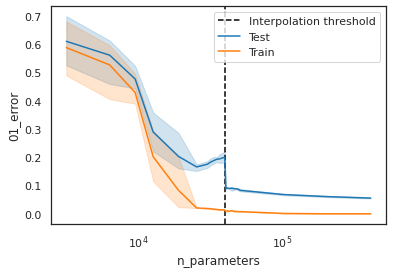

In [3]:
sns.set_style('white')
sns.set_context('notebook')

plot_df = df

fig, ax = plt.subplots(1, 1, sharex=True)

ax.axvline(10*df['n_train_samples'].iloc[0], ls='--', c='black', label='Interpolation threshold')

sns.lineplot(
    data=plot_df, x='n_parameters', y=test_error,
    ax=ax, label='Test')
sns.lineplot(
    data=plot_df, x='n_parameters', y=train_error,
    ax=ax, label='Train')

plt.xscale('log')
plt.ylabel(metric)
plt.legend()
plt.show()

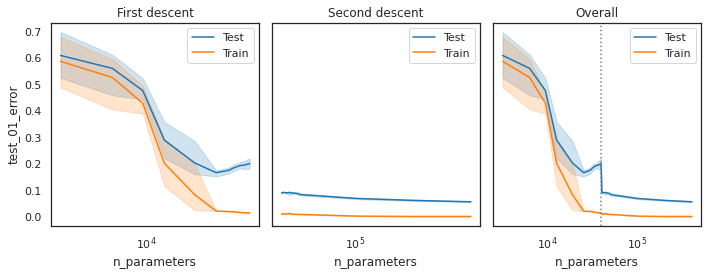

,First_descent,Second_descent,Overall
generalization_gap,1.000000,1.000000,1.000000
test_01_error,-0.409717,0.949532,0.256029
n_parameters,0.936476,-0.735664,-0.152443
width,0.936476,-0.735664,-0.152443
IRM_L1,-0.937854,-0.746324,-0.763361
IRM_L2,-0.959109,-0.656417,-0.830343
n_regions,0.925755,-0.841871,-0.163241
ACTS_L2,-0.790891,0.829873,0.183602
IRM_h*,-0.734345,0.528278,-0.336706
ACTS_h*,-0.795323,0.111392,0.112127


In [5]:
## Correlation variables
corr_vars = [
    'generalization_gap', test_error,
    'n_parameters', 'width',
    'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2',
    'IRM_h*', 'ACTS_h*', 'IRM_entropy', # 'IRM_entropy_normalized',
    'IRM_rows_mean_L2',
    'IRM_cols_mean_L1', 'IRM_cols_mean_L2',
    'IRM_mean_dot_product', 'IRM_mean_sim_entropy',
]

x_var = 'n_parameters'
interp = 10*df['n_train_samples'].iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)

for ax, idx, title in zip(
    axes,
    (
        df[x_var] <= interp,
        df[x_var] >= interp,
        df[x_var] > 0,
    ),
    ('First descent', 'Second descent', 'Overall')
):
    plot_df = df[idx]
    sns.lineplot(
        data=plot_df, x=x_var, y=test_error,
        ax=ax, label='Test')
    sns.lineplot(
        data=plot_df, x=x_var, y=train_error,
        ax=ax, label='Train')
    ax.set_xscale('log')
    ax.set_title(title)

axes[2].axvline(interp, ls=':', c='grey', label='Interpolation threshold')
plt.tight_layout()
plt.show()

corr_df = df[df[x_var] <= interp][corr_vars].corr('spearman')
series1 = corr_df['generalization_gap']

corr_df = df[df[x_var] >= interp][corr_vars].corr('spearman')
series2 = corr_df['generalization_gap']

corr_df = df[corr_vars].corr('spearman')
series3 = corr_df['generalization_gap']

corr_df = pd.concat((series1, series2, series3), axis=1)
corr_df.columns = ['First_descent', 'Second_descent', 'Overall']

display(corr_df)

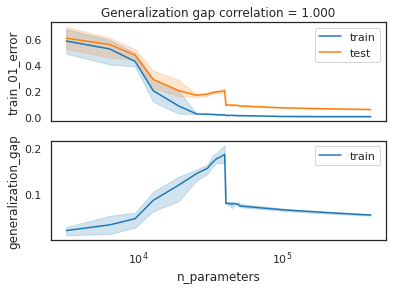

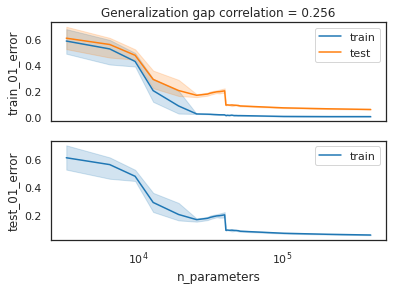

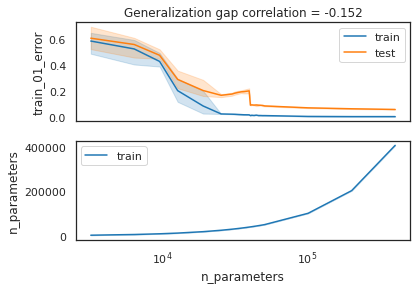

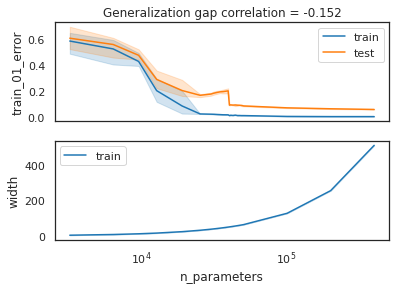

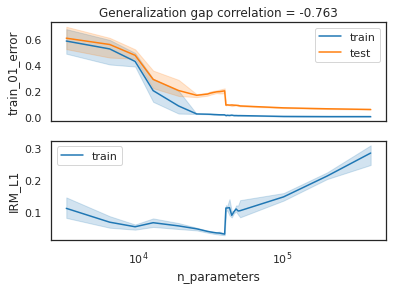

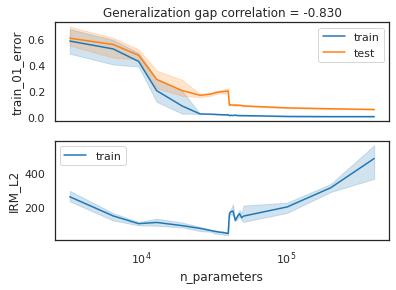

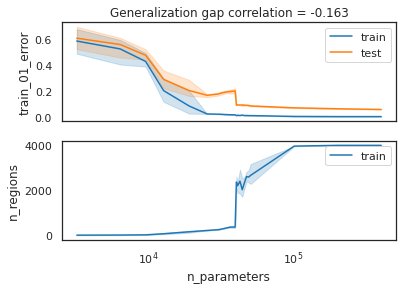

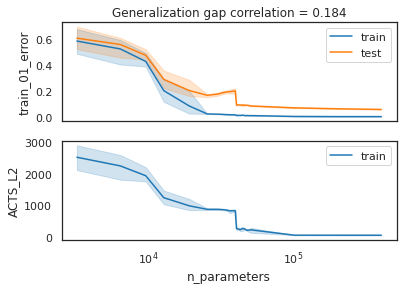

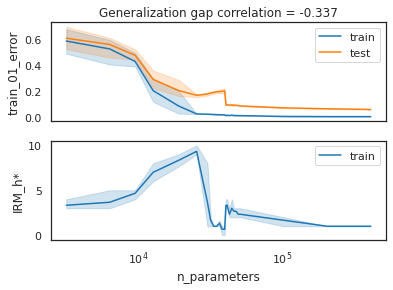

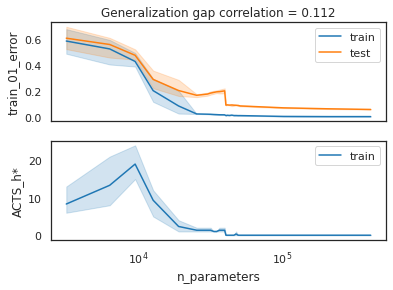

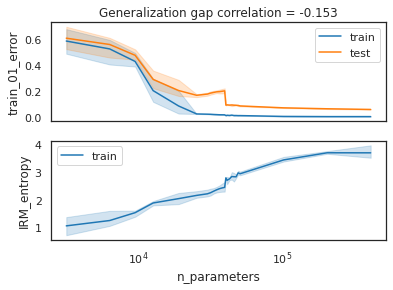

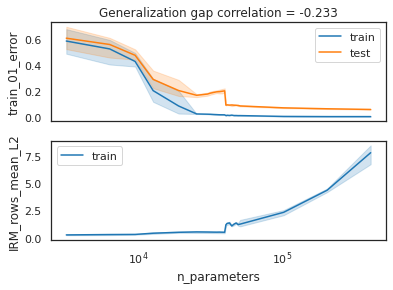

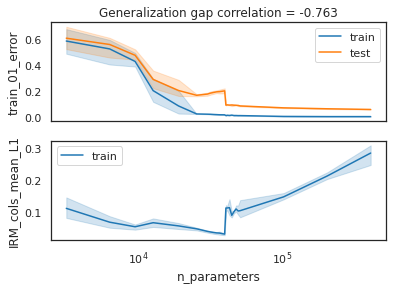

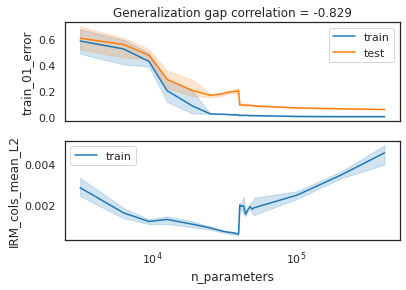

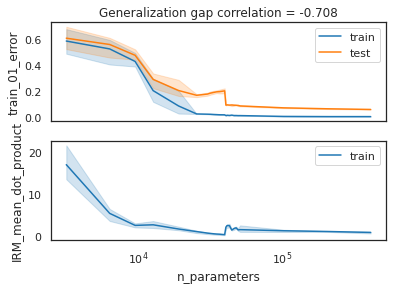

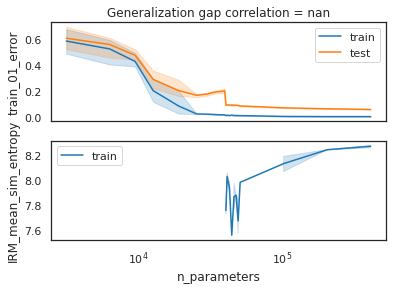

In [6]:
for var in corr_vars:
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
            
    sns.lineplot(
        data=plot_df, x='n_parameters', y=train_error,
        ax=ax1, label='train')
    sns.lineplot(
        data=plot_df, x='n_parameters', y=test_error,
        ax=ax1, label='test')
    sns.lineplot(
        data=plot_df, x='n_parameters', y=var,
        ax=ax2, label='train')

    plt.xscale('log')
    
#     if var in ['connected_partitions_fraction']:
#         ax2.set_yscale('symlog', linthresh=1e-2)
#     else:
    # ax2.set_yscale('log')
    corr, _ = spearmanr(df['generalization_gap'], df[var])
    ax1.set_title(f'Generalization gap correlation = {corr:.3f}')
    plt.legend()
    plt.show()

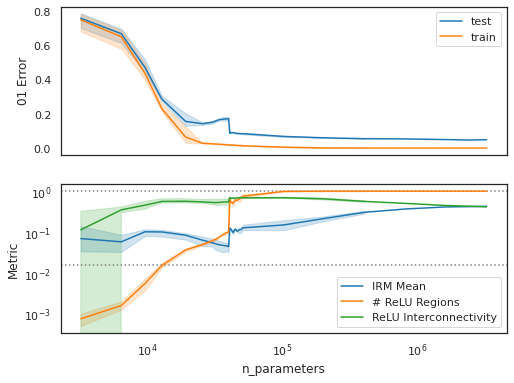

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

plot_df = df.copy()
plot_df["n_regions"] = plot_df["n_regions"] / plot_df["n_train_samples"]
plot_df["ACTS_L2"] = plot_df["ACTS_L2"] / plot_df["n_train_samples"]

ax2.axhline(1, ls=':', c='grey')
ax2.axhline(
    1 / np.sqrt(plot_df[plot_df["rep"] == 0]['n_train_samples'].iloc[0]),
    ls=':', c='grey')

x_var = 'n_parameters'
sns.lineplot(
    data=plot_df, x=x_var, y=test_error,
    ax=ax1, label='test')
sns.lineplot(
    data=plot_df, x=x_var, y=train_error,
    ax=ax1, label='train')

x_var = 'n_parameters'
sns.lineplot(
    data=plot_df, x=x_var, y='IRM_L1',
    ax=ax2, label='IRM Mean')
sns.lineplot(
    data=plot_df, x=x_var, y="n_regions",
    ax=ax2, label="# ReLU Regions")
sns.lineplot(
    data=plot_df, x=x_var, y="IRM_entropy_normalized",
    ax=ax2, label="ReLU Interconnectivity")

# ax2.plot(
#     plot_df[plot_df["rep"] == 0]["n_parameters"],
#     1 / plot_df[plot_df["rep"] == 0]["width"],
#     ls='--', c='black', label='1/# Relus')

# sns.lineplot(
#     data=plot_df, x='n_parameters', y="width",
#     ax=ax3, label="# ReLUs")

ax1.set_xscale('log')
ax1.set_ylabel('01 Error')

ax2.set_yscale('log')#, linthresh=1e-3)
ax2.set_ylabel("Metric")
# ax2.set_xscale('log')

plt.legend()
plt.show()

## notepad

Thoughts:
- region complexity should be L1 (a parameter in one region moved to another should be the same overall complexity for equal sized regions)

- size complexity should be L1?

Metric notes:

- metric = sum_{unique regions} (size * region complexity) = sum_{regions} region_complexity = sum of matrix = col_mean_L1 * n_samples

- metric = col_mean_L2 ~ sum_{regions} region_complexity^2 = sum_{unique_regions} size * region_complexity^2

## Forest

In [28]:
#
algo = "forest"
dataset = "mnist"

# Read
df = pd.read_csv(f'./results/{dataset}/{dataset}_{algo}_results.csv')


# Define headers
metric = "mse"
train_error = f'train_{metric}'
test_error = f'test_{metric}'

# Set to floats
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass

# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]
df["IRM_cols_mean_L1"] = df["IRM_cols_mean_L1"] / df["n_train_samples"]
df["IRM_cols_mean_L2"] = df["IRM_cols_mean_L2"] / df["n_train_samples"]
df['IRM_L1'] = df["IRM_L1"] / df["n_train_samples"]


# df['IRM_entropy_max'] = df.apply(
#     lambda row: entropy([1]*int(min(row['n_total_leaves'], row['n_train_samples']))),
#     axis=1)

# df['IRM_entropy_normalized'] = df.apply(
#     lambda row: row['IRM_entropy'] / row['IRM_entropy_max'],
#     axis=1)

# Average across reps
df = df.groupby(
    ['model', 'n_train_samples', 'max_depth', 'n_estimators'],
    as_index=False,
).mean()

# max_leaves = df.loc[
#     (df['n_estimators'] == 1) & (df['max_depth'] != 'None'),
#     'max_depth'
# ].astype(int).max()
# df['forest_capacity'] = df['']

# df.loc[
#     (df['n_estimators'] > 1) & (df['max_depth'] != 'None'),
#     'max_depth'
# ] = max_leaves

# df['n_max_leaves'] = max_leaves * df['n_estimators']

df.head(5)

,model,n_train_samples,max_depth,n_estimators,rep,n_test_samples,onehot,bootstrap,n_jobs,train_01_error,...,IRM_h*,ACTS_h*,IRM_entropy,IRM_rows_mean_L2,IRM_cols_mean_L1,IRM_cols_mean_L2,IRM_mean_dot_product,IRM_mean_sim_entropy,n_total_leaves,generalization_gap
0,forest,10000.0,1,1.0,0.0,10000.0,1.0,0.0,-2.0,0.8000,...,2.0,2.0,0.628219,0.750673,0.500000,0.005000,5635.1048,8.582122,2.0,-0.000105
1,forest,10000.0,10,1.0,0.0,10000.0,1.0,0.0,-2.0,0.0594,...,12.0,0.0,4.370601,0.187381,0.001927,0.000019,351.1146,4.839740,519.0,0.025154
2,forest,10000.0,11,1.0,0.0,10000.0,1.0,0.0,-2.0,0.0368,...,12.0,0.0,4.455516,0.186033,0.001541,0.000015,346.0844,4.754824,649.0,0.029397
3,forest,10000.0,12,1.0,0.0,10000.0,1.0,0.0,-2.0,0.0223,...,12.0,0.0,4.505801,0.185236,0.001326,0.000013,343.1246,4.704540,754.0,0.032831
4,forest,10000.0,13,1.0,0.0,10000.0,1.0,0.0,-2.0,0.0131,...,12.0,0.0,4.538910,0.184509,0.001208,0.000012,340.4364,4.671430,828.0,0.035449


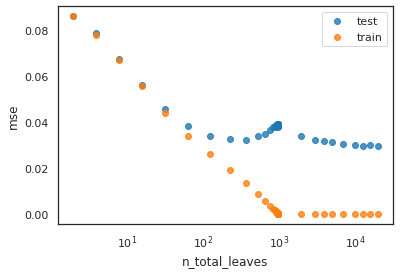

In [29]:
sns.set_style('white')
sns.set_context('notebook')

plot_df = df # [df["n_estimators"] > 1]

fig, ax = plt.subplots(1, 1, sharex=True)

sns.regplot(
    data=plot_df, x='n_total_leaves', y=test_error, lowess=False,
    ax=ax, label='test', fit_reg=False, x_ci=90)
sns.regplot(
    data=plot_df, x='n_total_leaves', y=train_error, lowess=False,
    ax=ax, label='train', fit_reg=False, x_ci=90)

# ax.axvline(10*df['n_train_samples'].iloc[0], ls='--', c='black', label='interp_threshold')
plt.xscale('log')
# plt.yscale('symlog')
plt.ylabel(metric)
plt.legend()
plt.show()

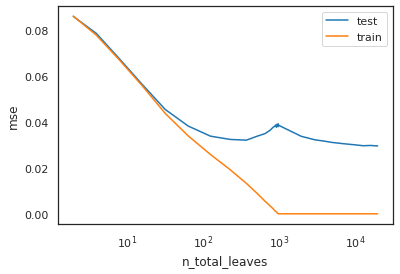

In [30]:
sns.set_style('white')
sns.set_context('notebook')

plot_df = df

fig, ax = plt.subplots(1, 1, sharex=True)

sns.lineplot(
    data=df, x='n_total_leaves', y=test_error,
    ax=ax, label='test')
sns.lineplot(
    data=df, x='n_total_leaves', y=train_error,
    ax=ax, label='train')

plt.xscale('log')
plt.ylabel(metric)
plt.legend()
plt.show()

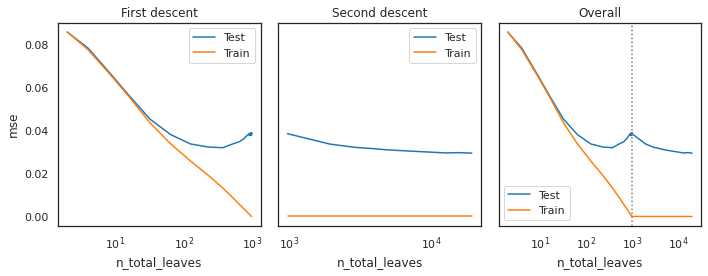

,First_descent,Second_descent,Overall
generalization_gap,1.000000,1.000000,1.000000
test_mse,0.107453,1.000000,0.215385
n_total_leaves,0.931508,-0.980597,0.463720
n_estimators,NaN,-0.980597,-0.204412
IRM_L0,0.931508,-0.980581,0.464016
IRM_L1,NaN,-0.881194,-0.198226
IRM_L2,-0.939907,0.867417,-0.477222
n_regions,0.931508,-0.979195,0.463845
ACTS_L2,-0.939907,0.955816,-0.471350
IRM_h*,-0.357711,NaN,-0.196552


In [31]:
## Correlation variables
corr_vars = [
    'generalization_gap', test_error,
    'n_total_leaves', 'n_estimators',
    'IRM_L0', 'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2',
    'IRM_h*', 'ACTS_h*', 'IRM_entropy',
    'IRM_rows_mean_L2',
    'IRM_cols_mean_L1', 'IRM_cols_mean_L2',
    'IRM_mean_dot_product', 'IRM_mean_sim_entropy',
]

x_var = 'n_total_leaves'
# U_argmin = 700
interp = df[df['n_estimators']==1]['n_total_leaves'].max()

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
# Join ascent/second descent y-axes
# axes[1].get_shared_y_axes().join(axes[1], axes[2])

for ax, idx, title in zip(
    axes,
    (
        df[x_var] <= interp,
        # (df[x_var] >= U_argmin) & (df[x_var] <= interp),
        df[x_var] >= interp,
        df[x_var] > 0,
    ),
    ('First descent', 'Second descent', 'Overall')
):
    plot_df = df[idx]
    sns.lineplot(
        data=plot_df, x=x_var, y=test_error,
        ax=ax, label='Test')
    sns.lineplot(
        data=plot_df, x=x_var, y=train_error,
        ax=ax, label='Train')
    ax.set_xscale('log')
    ax.set_title(title)

# axes[3].axvline(df[df[x_var] == U_argmin][x_var].iloc[0], ls=':', c='grey', label='U argmin')
axes[2].axvline(interp, ls=':', c='grey', label='Interpolation threshold')
axes[0].set_ylabel(metric)
plt.tight_layout()
plt.show()

corr_df = df[df[x_var] <= interp][corr_vars].corr('spearman')
series1 = corr_df['generalization_gap']

corr_df = df[df[x_var] >= interp][corr_vars].corr('spearman')
series2 = corr_df['generalization_gap']

corr_df = df[corr_vars].corr('spearman')
series3 = corr_df['generalization_gap']

corr_df = pd.concat((series1, series2, series3), axis=1)
corr_df.columns = ['First_descent', 'Second_descent', 'Overall']

display(corr_df)

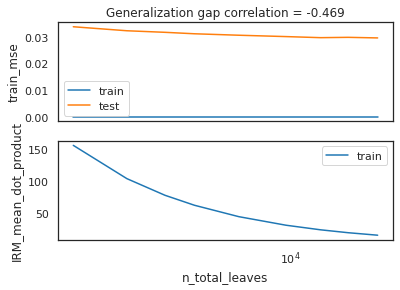

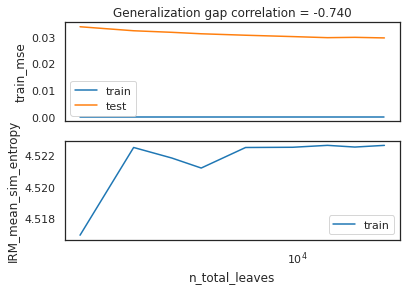

In [32]:
plot_vars = [
#     'IRM_L0', 'IRM_L1', 'IRM_L2', 'n_regions',
#     'IRM_entropy',
#     'IRM_rows_mean_L2',
    'IRM_mean_dot_product', 'IRM_mean_sim_entropy',
]

plot_df = df
x_var = 'n_total_leaves'

for var in plot_vars:
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
            
    sns.lineplot(
        data=plot_df, x=x_var, y=train_error,
        ax=ax1, label='train')
    sns.lineplot(
        data=plot_df, x=x_var, y=test_error,
        ax=ax1, label='test')
    sns.lineplot(
        data=plot_df, x=x_var, y=var,
        ax=ax2, label='train')

    plt.xscale('log')
    
#     if var in ['connected_partitions_fraction']:
#         ax2.set_yscale('symlog', linthresh=1e-2)
#     else:
    # ax2.set_yscale('log')
    corr, _ = spearmanr(df['generalization_gap'], df[var])
    ax1.set_title(f'Generalization gap correlation = {corr:.3f}')
    plt.legend()
    plt.show()

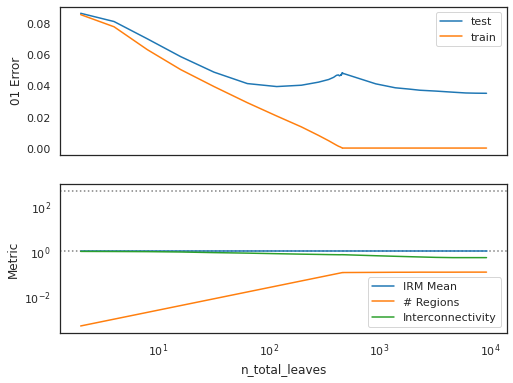

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

plot_df = df.copy()
plot_df["n_regions"] = plot_df["n_regions"] / plot_df["n_train_samples"]
plot_df["ACTS_L2"] = plot_df["ACTS_L2"] / plot_df["n_train_samples"]

ax2.axhline(1, ls=':', c='grey')
interp = df[df['n_estimators']==1]['n_total_leaves'].max()
ax2.axhline(
    interp,
    ls=':', c='grey')

x_var = 'n_total_leaves'
sns.lineplot(
    data=plot_df, x=x_var, y=test_error,
    ax=ax1, label='test')
sns.lineplot(
    data=plot_df, x=x_var, y=train_error,
    ax=ax1, label='train')

sns.lineplot(
    data=plot_df, x=x_var, y='IRM_L1',
    ax=ax2, label='IRM Mean')
sns.lineplot(
    data=plot_df, x=x_var, y="n_regions",
    ax=ax2, label="# Regions")
sns.lineplot(
    data=plot_df, x=x_var, y="IRM_entropy_normalized",
    ax=ax2, label="Interconnectivity")


ax1.set_xscale('log')
ax1.set_ylabel('01 Error')

ax2.set_yscale('log')#, linthresh=1e-3)
ax2.set_ylabel("Metric")
# ax2.set_xscale('log')

plt.legend()
plt.show()

## Random relu features

In [24]:
#
algo = "rrf"
dataset = "mnist"

# Read
df = pd.read_csv(f'./results/{dataset}/{dataset}_{algo}_results.csv')

# Define headers
metric = "01_error"
train_error = f'train_{metric}'
test_error = f'test_{metric}'

# Set to floats
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass

# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]
df["IRM_cols_mean_L1"] = df["IRM_cols_mean_L1"] / df["n_train_samples"]
df["IRM_cols_mean_L2"] = df["IRM_cols_mean_L2"] / df["n_train_samples"]
df['IRM_L1'] = df["IRM_L1"] / df["n_train_samples"]


# df['IRM_entropy_max'] = df.apply(
#     lambda row: entropy([1]*int(min(row['out_features'], row['n_train_samples']))),
#     axis=1)

# df['IRM_entropy_normalized'] = df.apply(
#     lambda row: row['IRM_entropy'] / row['IRM_entropy_max'],
#     axis=1)

# Average across reps
df = df.groupby(
    ['model', 'n_train_samples', 'out_features'],
    as_index=False,
).mean()

# df['connected_partitions_fraction'] = df['IRM_L0'] / df['width']

# Average across reps
df = df.groupby(
    ['model', 'n_train_samples', 'out_features'],
    as_index=False,
).mean()

df.head(5)

,model,n_train_samples,out_features,rep,n_test_samples,onehot,alpha,max_iter,batch_size,learning_rate_init,...,ACTS_L2,IRM_h*,ACTS_h*,IRM_entropy,IRM_rows_mean_L2,IRM_cols_mean_L1,IRM_cols_mean_L2,IRM_mean_dot_product,IRM_mean_sim_entropy,generalization_gap
0,rrf,1000.0,10.0,0.0,10000.0,1.0,0.0,500.0,32.0,0.01,...,101.341008,10.0,0.0,1.350627,1.758024,0.50650,0.016753,30.906490,6.824472,0.0611
1,rrf,1000.0,20.0,0.0,10000.0,1.0,0.0,500.0,32.0,0.01,...,34.928498,1.0,0.0,1.613812,2.554790,0.51170,0.016455,16.317375,6.883045,0.0359
2,rrf,1000.0,50.0,0.0,10000.0,1.0,0.0,500.0,32.0,0.01,...,31.622777,1.0,0.0,1.796147,4.187792,0.52488,0.016719,7.015042,6.897560,0.0919
3,rrf,1000.0,100.0,0.0,10000.0,1.0,0.0,500.0,32.0,0.01,...,31.622777,1.0,0.0,2.131789,5.694178,0.50652,0.016078,3.242367,6.900806,0.1128
4,rrf,1000.0,200.0,0.0,10000.0,1.0,0.0,500.0,32.0,0.01,...,31.622777,1.0,0.0,2.468658,7.773384,0.49628,0.015727,1.510637,6.902289,0.1448


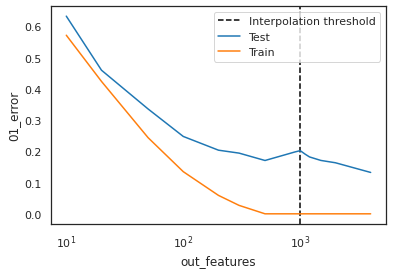

In [25]:
sns.set_style('white')
sns.set_context('notebook')

plot_df = df

fig, ax = plt.subplots(1, 1, sharex=True)

ax.axvline(df['n_train_samples'].iloc[0], ls='--', c='black', label='Interpolation threshold')
x_var = 'out_features'

sns.lineplot(
    data=plot_df, x=x_var, y=test_error,
    ax=ax, label='Test')
sns.lineplot(
    data=plot_df, x=x_var, y=train_error,
    ax=ax, label='Train')

plt.xscale('log')
plt.ylabel(metric)
plt.legend()
plt.show()

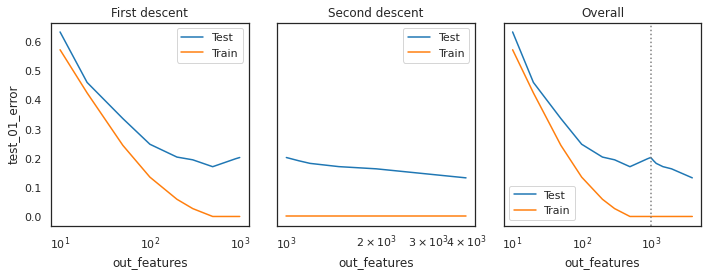

,First_descent,Second_descent,Overall
generalization_gap,1.000000,1.000000,1.000000
test_01_error,-0.781818,1.000000,-0.425000
out_features,0.987879,-1.000000,0.571429
IRM_L1,-0.139394,0.371429,-0.046429
IRM_L2,-0.490909,0.257143,-0.303571
n_regions,0.683349,NaN,0.585571
ACTS_L2,-0.683349,NaN,-0.585571
IRM_h*,-0.406181,NaN,-0.371154
ACTS_h*,NaN,NaN,NaN
IRM_entropy,0.975758,-0.942857,0.567857


In [26]:
## Correlation variables
corr_vars = [
    'generalization_gap', test_error,
    'out_features',
    'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2',
    'IRM_h*', 'ACTS_h*', 'IRM_entropy',
    'IRM_rows_mean_L2',
    'IRM_cols_mean_L1', 'IRM_cols_mean_L2',
    'IRM_mean_dot_product', 'IRM_mean_sim_entropy',
]

x_var = 'out_features'
# U_argmin = 700
interp = df['n_train_samples'].iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
# Join ascent/second descent y-axes
# axes[1].get_shared_y_axes().join(axes[1], axes[2])

for ax, idx, title in zip(
    axes,
    (
        df[x_var] <= interp,
        # (df[x_var] >= U_argmin) & (df[x_var] <= interp),
        df[x_var] >= interp,
        df[x_var] > 0,
    ),
    ('First descent', 'Second descent', 'Overall')
):
    plot_df = df[idx]
    sns.lineplot(
        data=plot_df, x=x_var, y=test_error,
        ax=ax, label='Test')
    sns.lineplot(
        data=plot_df, x=x_var, y=train_error,
        ax=ax, label='Train')
    ax.set_xscale('log')
    ax.set_title(title)

# axes[3].axvline(df[df[x_var] == U_argmin][x_var].iloc[0], ls=':', c='grey', label='U argmin')
axes[2].axvline(interp, ls=':', c='grey', label='Interpolation threshold')
plt.tight_layout()
plt.show()

corr_df = df[df[x_var] <= interp][corr_vars].corr('spearman')
series1 = corr_df['generalization_gap']

corr_df = df[df[x_var] >= interp][corr_vars].corr('spearman')
series2 = corr_df['generalization_gap']

corr_df = df[corr_vars].corr('spearman')
series3 = corr_df['generalization_gap']

corr_df = pd.concat((series1, series2, series3), axis=1)
corr_df.columns = ['First_descent', 'Second_descent', 'Overall']

display(corr_df)

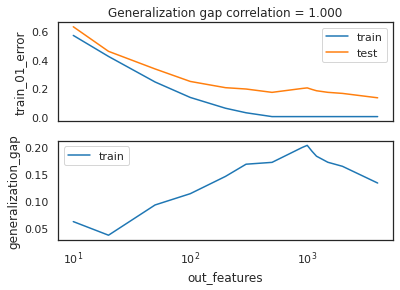

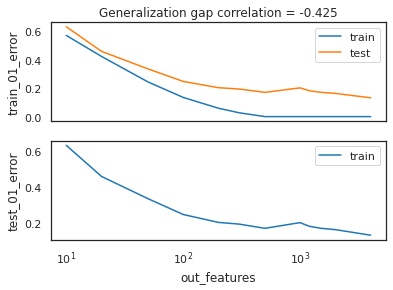

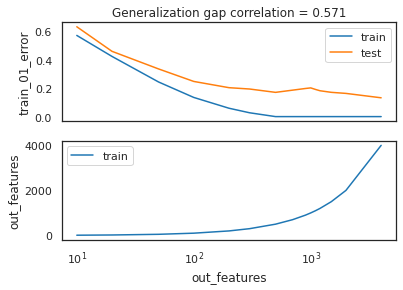

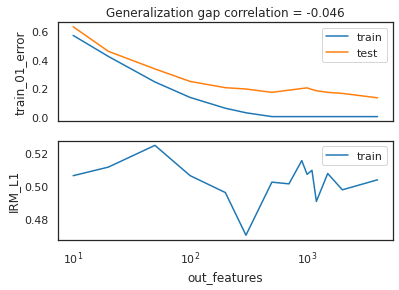

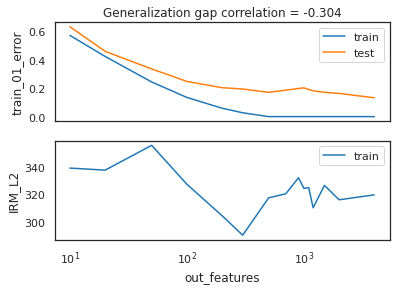

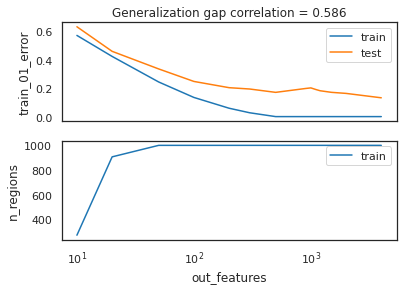

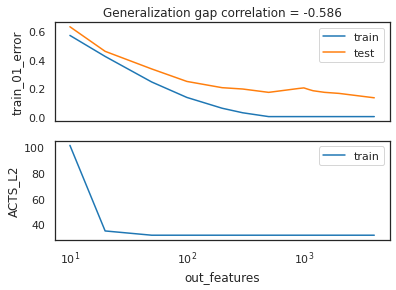

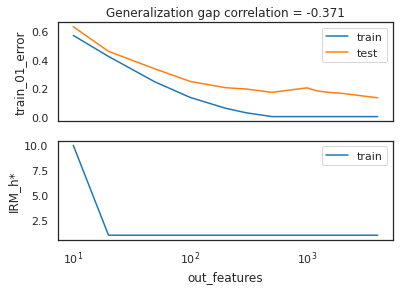

/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


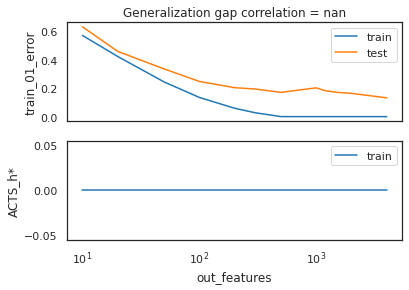

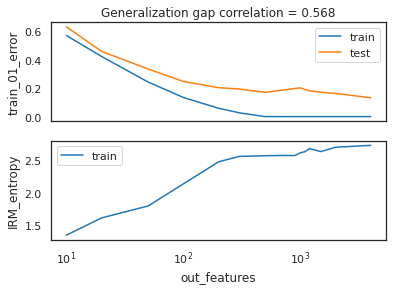

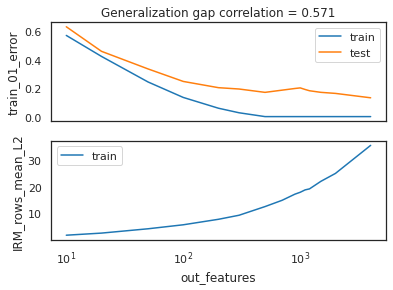

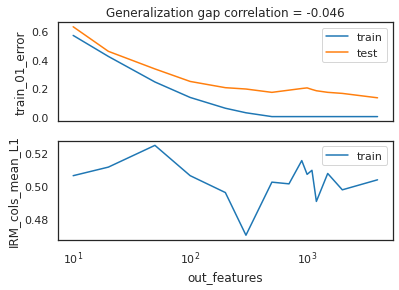

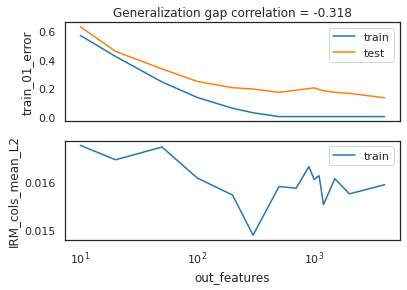

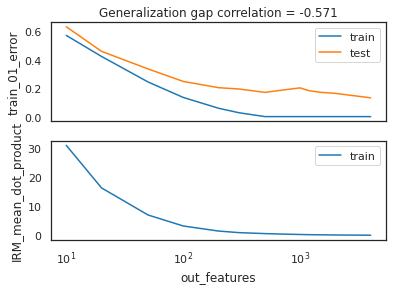

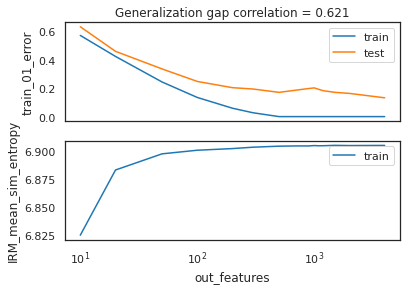

In [27]:
for var in corr_vars:
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
            
    x_var = 'out_features'
    sns.lineplot(
        data=plot_df, x=x_var, y=train_error,
        ax=ax1, label='train')
    sns.lineplot(
        data=plot_df, x=x_var, y=test_error,
        ax=ax1, label='test')
    sns.lineplot(
        data=plot_df, x=x_var, y=var,
        ax=ax2, label='train')

    plt.xscale('log')
    
#     if var in ['connected_partitions_fraction']:
#         ax2.set_yscale('symlog', linthresh=1e-2)
#     else:
    # ax2.set_yscale('log')
    corr, _ = spearmanr(df['generalization_gap'], df[var])
    ax1.set_title(f'Generalization gap correlation = {corr:.3f}')
    plt.legend()
    plt.show()